In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"erickumara","key":"b0c5c0a20bb90c102a85f16e4a1728b4"}')

!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Datasets
# https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset 7 columns
# https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset 2 columns

!mkdir '/content/data'

!kaggle datasets download -d naserabdullahalam/phishing-email-dataset
!unzip -qo 'phishing-email-dataset.zip' -d '/content/data'
!rm 'phishing-email-dataset.zip'

!kaggle datasets download -d llabhishekll/fraud-email-dataset
!unzip -qo 'fraud-email-dataset.zip' -d '/content/data'
!rm 'fraud-email-dataset.zip'

mkdir: cannot create directory ‘/content/data’: File exists
Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset
License(s): unknown


In [ ]:
import os
import requests
import tarfile
import email
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
from transformers import BertTokenizer


import os

data_path = "/content/data"

all_df = []

for file in os.listdir(data_path):
    df = pd.read_csv(os.path.join(data_path, file))

    # Normalizing all datasets to columns: body, label
    if {'body', 'label'}.issubset(df.columns):
        pass
    elif {'Text', 'Class'}.issubset(df.columns):
        df = df.rename(columns={'Text':'body','Class':'label'})
    elif {'text_combined','label'}.issubset(df.columns):
        df = df.rename(columns={'text_combined':'body'})
    elif 'message' in df.columns:
        df = df.rename(columns={'message':'body'})

    df = df[['body','label']]
    all_df.append(df)

    print(f"Loaded: {file}")
    print(df.head(1))
    print("-"*40)

df = pd.concat(all_df, ignore_index=True)
df.dropna(inplace=True)
df['label'] = df['label'].astype(int)

df.head()



Loaded: SpamAssasin.csv
                                                body  label
0  Date:        Wed, 21 Aug 2002 10:54:46 -0500  ...      0
----------------------------------------
Loaded: fraud_email_.csv
                                                body  label
0  Supply Quality China's EXCLUSIVE dimensions at...      1
----------------------------------------
Loaded: Nazario.csv
                                                body  label
0  This text is part of the internal format of yo...      1
----------------------------------------
Loaded: Nigerian_Fraud.csv
                                                body  label
0  FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...      1
----------------------------------------
Loaded: Ling.csv
                                                body  label
0  content - length : 3386 apple-iss research cen...      0
----------------------------------------
Loaded: Enron.csv
                                                body  label
0  (

,body,label
0,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,Man Threatens Explosion In Moscow \n\nThursday...,0
3,Klez: The Virus That Won't Die\n \nAlready the...,0
4,"> in adding cream to spaghetti carbonara, whi...",0


In [ ]:

from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.output_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        # Linear projections
        q = self.query(x).view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        k = self.key(x).view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        v = self.value(x).view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)

        # Attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_size ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, v)

        # Reshape
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)
        output = self.output_linear(context)

        return output

# Define FeedForward network
class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_size):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, ff_size)
        self.fc2 = nn.Linear(ff_size, hidden_size)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

# Define EncoderBlock
class EncoderBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_size, dropout=0.1):
        super().__init__()
        self.layernorm = nn.LayerNorm(hidden_size)
        self.self_multihead = MultiHeadAttention(hidden_size, num_heads)
        self.feed_forward = FeedForward(hidden_size, ff_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attention_output = self.self_multihead(self.layernorm(x), mask)
        x = x + self.dropout(attention_output)

        # Feed-forward
        ff_output = self.feed_forward(self.layernorm(x))
        x = x + self.dropout(ff_output)

        return x

# Define BERTEmbedding
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_seq_len=64, dropout=0.1):
        super().__init__()
        self.token = nn.Embedding(vocab_size, hidden_size)
        self.segment = nn.Embedding(3, hidden_size)
        self.position = nn.Module()
        self.position.pe = nn.Parameter(torch.zeros(1, max_seq_len, hidden_size))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, segment=None):
        seq_len = x.size(1)

        # Token embedding
        token_embedding = self.token(x)

        # Position embedding
        position_embedding = self.position.pe[:, :seq_len, :]

        # Segment embedding
        if segment is not None:
            segment_embedding = self.segment(segment)
            embedding = token_embedding + position_embedding + segment_embedding
        else:
            embedding = token_embedding + position_embedding

        return self.dropout(embedding)

# Define BERT model
class BERT(nn.Module):
    def __init__(self, vocab_size, hidden_size=768, num_layers=12, num_heads=12, ff_size=3072, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size

        # Embedding
        self.embedding = BERTEmbedding(vocab_size, hidden_size, dropout=dropout)

        # Transformer blocks
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(hidden_size, num_heads, ff_size, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, segment=None, mask=None):
        # Create attention mask if not provided
        if mask is None:
            mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # Embedding
        x = self.embedding(x, segment)

        # Transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder(x, mask)

        return x

# Define NextSentencePrediction
class NextSentencePrediction(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear = nn.Linear(hidden_size, 2)

    def forward(self, x):
        return F.log_softmax(self.linear(x[:, 0]), dim=-1)

# Define MaskedLanguageModel
class MaskedLanguageModel(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super().__init__()
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=-1)

# Define BERTLM
class BERTLM(nn.Module):
    def __init__(self, bert_model, vocab_size):
        super().__init__()
        self.bert = bert_model
        self.next_sentence = NextSentencePrediction(bert_model.hidden_size)
        self.mask_lm = MaskedLanguageModel(bert_model.hidden_size, vocab_size)

    def forward(self, x, segment=None):
        bert_output = self.bert(x, segment)
        return self.next_sentence(bert_output), self.mask_lm(bert_output)

# Define EmailDataset for training
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros_like(encoding['attention_mask'])).flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Define BERTSpamClassifier
class BERTSpamClassifier(nn.Module):
    def __init__(self, bert_model):
        super(BERTSpamClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1)  # Binary classification

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Forward pass through BERT
        outputs = self.bert(input_ids, segment=token_type_ids)

        # Use the [CLS] token for classification
        pooled_output = outputs[:, 0]

        # Dropout and classify
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

Mounted at /content/gdrive


In [ ]:

# Set device
import torch
from torch import nn
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


# 2. Preprocess data
def clean_text(text):
    import re
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['body'] = df['body'].apply(clean_text)

# 3. Split data: 90% train, 10% test
X_train, X_test, y_train, y_test = train_test_split(
    df['body'], df['label'], test_size=0.2, random_state=42
)

# 4. Load model and tokenizer
import torch.serialization
torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])

# Paths to your model and tokenizer
MODEL_PATH = '/content/gdrive/MyDrive/email_bert/110M_Bert.pth'

TOKENIZER_PATH = '/content/gdrive/MyDrive/email_bert/tokenizer/bert-email-vocab.txt'
tokenizer = BertTokenizer(
    vocab_file=TOKENIZER_PATH,
    do_lower_case=True
)

# Create BERT model
bert_model = BERT(vocab_size=len(tokenizer.vocab))
bert_lm = BERTLM(bert_model, len(tokenizer.vocab))

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)

# Load state dict
try:
    bert_lm.load_state_dict(checkpoint['model_state_dict'])
    print("Successfully loaded model weights from checkpoint!")
except Exception as e:
    print(f"Error loading model weights: {e}")

# Create classifier
spam_classifier = BERTSpamClassifier(bert_lm.bert)

# 5. Create datasets and dataloaders
MAX_LEN = 64  # Max sequence length

train_dataset = EmailDataset(X_train.values, y_train.values, tokenizer, MAX_LEN)
test_dataset = EmailDataset(X_test.values, y_test.values, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# 6. Training
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(spam_classifier.parameters(), lr=2e-5)

spam_classifier.to(device)

# Training loop
epochs = 10
for epoch in range(epochs):
    # Training
    spam_classifier.train()
    train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = spam_classifier(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if step % 5000 == 0 and step > 0:
            print(f"Batch {step}, Loss: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average training loss: {avg_train_loss:.4f}")

    # Evaluation after each epoch
    spam_classifier.eval()
    y_preds = []
    y_true = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = spam_classifier(input_ids, attention_mask, token_type_ids)
            preds = torch.sigmoid(outputs.squeeze()) > 0.5

            y_preds.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(y_preds) == np.array(y_true))
    print(f"Accuracy: {accuracy:.4f}")

    # Detailed metrics
    report = classification_report(y_true, y_preds)
    print(report)




Using device: cuda
Successfully loaded model weights from checkpoint!


Epoch 1/10:  28%|██▊       | 5003/17690 [06:20<16:09, 13.09it/s]

Batch 5000, Loss: 0.4804


Epoch 1/10:  57%|█████▋    | 10003/17690 [14:20<08:36, 14.89it/s]

Batch 10000, Loss: 0.1819


Epoch 1/10:  85%|████████▍ | 15003/17690 [20:36<02:58, 15.03it/s]

Batch 15000, Loss: 0.0916


Epoch 1/10: 100%|██████████| 17690/17690 [23:58<00:00, 12.30it/s]


Epoch 1/10, Average training loss: 0.2563


Evaluating: 100%|██████████| 4423/4423 [03:28<00:00, 21.26it/s]


Accuracy: 0.9574
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     17352
         1.0       0.98      0.94      0.96     18028

    accuracy                           0.96     35380
   macro avg       0.96      0.96      0.96     35380
weighted avg       0.96      0.96      0.96     35380



Epoch 2/10:  28%|██▊       | 5001/17690 [06:26<15:07, 13.99it/s]

Batch 5000, Loss: 0.0749


Epoch 2/10:  57%|█████▋    | 10003/17690 [12:58<09:36, 13.33it/s]

Batch 10000, Loss: 0.0155


Epoch 2/10:  85%|████████▍ | 15004/17690 [20:04<03:15, 13.74it/s]

Batch 15000, Loss: 0.5197


Epoch 2/10: 100%|██████████| 17690/17690 [24:26<00:00, 12.06it/s]


Epoch 2/10, Average training loss: 0.1079


Evaluating: 100%|██████████| 4423/4423 [03:28<00:00, 21.23it/s]


Accuracy: 0.9306
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     17352
         1.0       0.99      0.87      0.93     18028

    accuracy                           0.93     35380
   macro avg       0.94      0.93      0.93     35380
weighted avg       0.94      0.93      0.93     35380



Epoch 3/10:  28%|██▊       | 5002/17690 [07:10<15:17, 13.83it/s]

Batch 5000, Loss: 0.0104


Epoch 3/10:  57%|█████▋    | 10003/17690 [13:43<10:02, 12.76it/s]

Batch 10000, Loss: 0.0028


Epoch 3/10:  85%|████████▍ | 15003/17690 [21:06<03:05, 14.46it/s]

Batch 15000, Loss: 0.0025


Epoch 3/10: 100%|██████████| 17690/17690 [24:32<00:00, 12.02it/s]


Epoch 3/10, Average training loss: 0.0797


Evaluating: 100%|██████████| 4423/4423 [03:27<00:00, 21.31it/s]


Accuracy: 0.9425
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94     17352
         1.0       1.00      0.89      0.94     18028

    accuracy                           0.94     35380
   macro avg       0.95      0.94      0.94     35380
weighted avg       0.95      0.94      0.94     35380



Epoch 4/10:  28%|██▊       | 5002/17690 [07:27<16:34, 12.75it/s]

Batch 5000, Loss: 0.0027


Epoch 4/10:  57%|█████▋    | 10002/17690 [13:55<09:19, 13.74it/s]

Batch 10000, Loss: 0.0160


Epoch 4/10:  85%|████████▍ | 15004/17690 [20:15<02:56, 15.21it/s]

Batch 15000, Loss: 0.0061


Epoch 4/10: 100%|██████████| 17690/17690 [24:16<00:00, 12.14it/s]


Epoch 4/10, Average training loss: 0.0659


Evaluating: 100%|██████████| 4423/4423 [03:25<00:00, 21.54it/s]


Accuracy: 0.8689
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     17352
         1.0       1.00      0.74      0.85     18028

    accuracy                           0.87     35380
   macro avg       0.89      0.87      0.87     35380
weighted avg       0.90      0.87      0.87     35380



Epoch 5/10:  28%|██▊       | 5004/17690 [07:17<15:21, 13.76it/s]

Batch 5000, Loss: 0.0242


Epoch 5/10:  57%|█████▋    | 10003/17690 [14:13<09:46, 13.11it/s]

Batch 10000, Loss: 0.0009


Epoch 5/10:  85%|████████▍ | 15002/17690 [20:39<03:22, 13.24it/s]

Batch 15000, Loss: 0.0422


Epoch 5/10: 100%|██████████| 17690/17690 [24:04<00:00, 12.24it/s]


Epoch 5/10, Average training loss: 0.0584


Evaluating: 100%|██████████| 4423/4423 [03:25<00:00, 21.51it/s]


Accuracy: 0.9505
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     17352
         1.0       0.99      0.91      0.95     18028

    accuracy                           0.95     35380
   macro avg       0.95      0.95      0.95     35380
weighted avg       0.95      0.95      0.95     35380



Epoch 6/10:  28%|██▊       | 5003/17690 [06:21<15:19, 13.80it/s]

Batch 5000, Loss: 0.0010


Epoch 6/10:  57%|█████▋    | 10003/17690 [12:41<08:18, 15.41it/s]

Batch 10000, Loss: 0.0311


Epoch 6/10:  85%|████████▍ | 15002/17690 [19:46<03:03, 14.62it/s]

Batch 15000, Loss: 0.0081


Epoch 6/10: 100%|██████████| 17690/17690 [24:05<00:00, 12.24it/s]


Epoch 6/10, Average training loss: 0.0519


Evaluating: 100%|██████████| 4423/4423 [03:25<00:00, 21.56it/s]


Accuracy: 0.9135
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     17352
         1.0       1.00      0.83      0.91     18028

    accuracy                           0.91     35380
   macro avg       0.92      0.92      0.91     35380
weighted avg       0.93      0.91      0.91     35380



Epoch 7/10:  28%|██▊       | 5004/17690 [06:22<14:44, 14.34it/s]

Batch 5000, Loss: 0.0098


Epoch 7/10:  57%|█████▋    | 10002/17690 [12:33<08:22, 15.30it/s]

Batch 10000, Loss: 0.0070


Epoch 7/10:  85%|████████▍ | 15004/17690 [20:29<02:52, 15.58it/s]

Batch 15000, Loss: 0.0001


Epoch 7/10: 100%|██████████| 17690/17690 [23:58<00:00, 12.30it/s]


Epoch 7/10, Average training loss: 0.0474


Evaluating: 100%|██████████| 4423/4423 [03:26<00:00, 21.45it/s]


Accuracy: 0.9622
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     17352
         1.0       1.00      0.93      0.96     18028

    accuracy                           0.96     35380
   macro avg       0.96      0.96      0.96     35380
weighted avg       0.96      0.96      0.96     35380



Epoch 8/10:  28%|██▊       | 5002/17690 [07:59<14:32, 14.54it/s]

Batch 5000, Loss: 0.1042


Epoch 8/10:  57%|█████▋    | 10003/17690 [14:27<10:04, 12.72it/s]

Batch 10000, Loss: 0.0057


Epoch 8/10:  85%|████████▍ | 15003/17690 [20:50<03:31, 12.73it/s]

Batch 15000, Loss: 0.1526


Epoch 8/10: 100%|██████████| 17690/17690 [24:09<00:00, 12.21it/s]


Epoch 8/10, Average training loss: 0.0431


Evaluating: 100%|██████████| 4423/4423 [03:26<00:00, 21.37it/s]


Accuracy: 0.9417
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94     17352
         1.0       1.00      0.89      0.94     18028

    accuracy                           0.94     35380
   macro avg       0.95      0.94      0.94     35380
weighted avg       0.95      0.94      0.94     35380



Epoch 9/10:  28%|██▊       | 5002/17690 [08:05<15:35, 13.57it/s]

Batch 5000, Loss: 0.0888


Epoch 9/10:  57%|█████▋    | 10003/17690 [14:33<10:22, 12.35it/s]

Batch 10000, Loss: 0.0019


Epoch 9/10:  85%|████████▍ | 15004/17690 [20:53<03:10, 14.08it/s]

Batch 15000, Loss: 0.0325


Epoch 9/10: 100%|██████████| 17690/17690 [24:20<00:00, 12.11it/s]


Epoch 9/10, Average training loss: 0.0395


Evaluating: 100%|██████████| 4423/4423 [03:25<00:00, 21.49it/s]


Accuracy: 0.9084
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91     17352
         1.0       1.00      0.82      0.90     18028

    accuracy                           0.91     35380
   macro avg       0.92      0.91      0.91     35380
weighted avg       0.92      0.91      0.91     35380



Epoch 10/10:  28%|██▊       | 5003/17690 [06:18<15:32, 13.60it/s]

Batch 5000, Loss: 0.0094


Epoch 10/10:  57%|█████▋    | 10002/17690 [13:37<09:56, 12.89it/s]

Batch 10000, Loss: 0.0001


Epoch 10/10:  85%|████████▍ | 15002/17690 [20:47<03:44, 11.98it/s]

Batch 15000, Loss: 0.0196


Epoch 10/10: 100%|██████████| 17690/17690 [24:08<00:00, 12.21it/s]


Epoch 10/10, Average training loss: 0.0373


Evaluating: 100%|██████████| 4423/4423 [03:24<00:00, 21.61it/s]


Accuracy: 0.9440
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     17352
         1.0       1.00      0.89      0.94     18028

    accuracy                           0.94     35380
   macro avg       0.95      0.95      0.94     35380
weighted avg       0.95      0.94      0.94     35380



In [ ]:
# 7. Final evaluation
spam_classifier.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Final evaluation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = spam_classifier(input_ids, attention_mask, token_type_ids)
        preds = torch.sigmoid(outputs.squeeze()) > 0.5

        y_preds.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())




Final evaluation: 100%|██████████| 4423/4423 [03:24<00:00, 21.63it/s]


Confusion matrix:
[[8640   35]
 [ 954 8059]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     17352
         1.0       1.00      0.89      0.94     18028

    accuracy                           0.94     35380
   macro avg       0.95      0.95      0.94     35380
weighted avg       0.95      0.94      0.94     35380

Model saved to /content/drive/MyDrive/email_bert/spam_classifier.pth


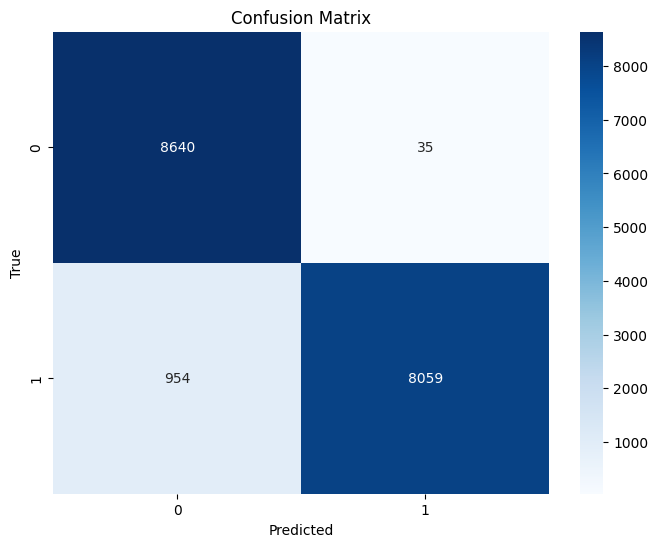

In [ ]:


# Confusion matrix
cm = confusion_matrix(y_true, y_preds)
cm = cm//2
print("Confusion matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/gdrive/MyDrive/email_bert/confusion_matrix.png')

# Classification report
report = classification_report(y_true, y_preds)
print("Classification report:")
print(report)

# Save model
torch.save(spam_classifier.state_dict(), '/content/gdrive/MyDrive/email_bert/spam_classifier.pth')
print("Model saved to /content/drive/MyDrive/email_bert/spam_classifier.pth")